In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

[]

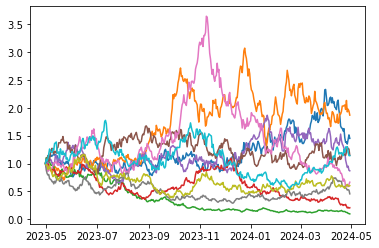

In [8]:
#price path format is a df with 2 columns: 'price' and 'date' (date is int)
#exact simulation of GBM with constant mu and sigma
#lecture 4 p21
def genGBM(s_0, t_0, mu, sigma, delta_t, n):
    df_path = pd.DataFrame(data={'price': [s_0], 'date': [t_0]})
    curDate = t_0
    curPrice = s_0
    for i in range(n):
        curDate += datetime.timedelta(days=1)
        z = np.random.normal()
        drift = (mu - np.power(sigma, 2) / 2) * delta_t
        diffusion = np.power(delta_t, 0.5) * sigma
        curPrice *= np.exp(drift + diffusion * z)
        newRow = pd.DataFrame(data={'price': [curPrice], 'date': [curDate]})
        df_path = pd.concat([df_path, newRow])
    return df_path

#viz of price paths
N = 10
pathArr = []
plt.figure()
for i in range(N):
    pathArr.append(genGBM(1, datetime.date.fromisoformat('2023-04-30'), 0.1, 1, 1/365, 365))
    plt.plot(pathArr[i]['date'], pathArr[i]['price'])
plt.plot()

In [13]:
#helper function to check barrier

def checkBarrier(df_path1, df_path2, barrierHit):
    return min(df_path1['price']) < 0.6 or min(df_path2['price']) < 0.6

#Initial fixing date: 27/04/23 -> 0
#Final fixing date: 30/07/24 (15 months) ->
#Early redemption dates: look at excel

#returns a df of payouts ('payout', 'date') based on underlying prices path1, path2
#paths should be from initial fixing date till maturity
#next step would be to vary starting date (include bool argument to indicate if barrier hit beforehand)
#also consider methods of making features (autocall, barrier) modular
def future_payouts(df_path1, df_path2, barrierHit):
    #init
    df_payouts = pd.DataFrame({'payout': [], 'date': []})
    first_date = df_path1.sort_values('date').iloc[0]['date']
    print(first_date)
    
    #Early redemption, does not yield dividends past called date
    triggerDate = datetime.date.fromisoformat('2024-07-30') #init to final fixing date
    redemptionDate = datetime.date.fromisoformat('2024-08-05') #init to final redemption date
    autocall_dates = [[datetime.date.fromisoformat('2023-11-01'), datetime.date.fromisoformat('2024-01-31'), datetime.date.fromisoformat('2024-04-30')],
                      [datetime.date.fromisoformat('2023-11-06'), datetime.date.fromisoformat('2024-02-05'), datetime.date.fromisoformat('2024-05-06')]]
    for i in range(len(autocall_dates[0])):
        date = autocall_dates[0][i]
        #only check dates after today
        if date >= first_date:
            #if both assets are above reference level on 'date'
            if df_path1.loc[df_path1['date'] == date].iloc[0]['price'] >= 1 and df_path2.loc[df_path2['date'] == date].iloc[0]['price'] >= 1:
                #print("autocall at {date}!".format(date=date))
                triggerDate = date
                redemptionDate = autocall_dates[1][i]
                break
    
    #barrier check
    if not barrierHit:
        barrierHit = checkBarrier(df_path1, df_path2)
    
    #dividend payment
    div_payment_dates = [datetime.date.fromisoformat('2023-08-07'), datetime.date.fromisoformat('2023-11-06'), datetime.date.fromisoformat('2024-02-05'), datetime.date.fromisoformat('2024-05-06'), datetime.date.fromisoformat('2024-08-05')]
    for date in div_payment_dates:
        #div payments after today
        if date > first_date:
            if date <= redemptionDate:
                div_payout = pd.DataFrame({'payout': [1000 * 0.02], 'date': [date]})
                df_payouts = pd.concat([df_payouts, div_payout])
    
    #Final redemption
    #if early redemption occured, payout = 1000 regardless of barrierHit since both underlyings would be > 1 anyways
    if barrierHit:
        path1Closing = df_path1.loc[df_path1['date'] == triggerDate].iloc[0]['price']
        path2Closing = df_path2.loc[df_path2['date'] == triggerDate].iloc[0]['price']
        worstPerforming = min(path1Closing, path2Closing, 1)
        final_payout = pd.DataFrame({'payout': [1000 * worstPerforming], 'date': [redemptionDate]})
    else:
        final_payout = pd.DataFrame({'payout': [1000], 'date': [redemptionDate]})
    df_payouts = pd.concat([df_payouts, final_payout])
    return df_payouts

#should yield higher payoff on average
def future_payouts_no_autocall(df_path1, df_path2, barrierHit):
    #init
    df_payouts = pd.DataFrame({'payout': [], 'date': []})
    first_date = df_path1.sort_values('date').iloc[0]['date']
    print(first_date)
    
    #Early redemption, does not yield dividends past called date
    triggerDate = datetime.date.fromisoformat('2024-07-30') #init to final fixing date
    redemptionDate = datetime.date.fromisoformat('2024-08-05') #init to final redemption date
    
    #barrier check
    if not barrierHit:
        barrierHit = checkBarrier(df_path1, df_path2)
    
    #dividend payment
    div_payment_dates = [datetime.date.fromisoformat('2023-08-07'), datetime.date.fromisoformat('2023-11-06'), datetime.date.fromisoformat('2024-02-05'), datetime.date.fromisoformat('2024-05-06'), datetime.date.fromisoformat('2024-08-05')]
    for date in div_payment_dates:
        #div payments after today
        if date > first_date:
            div_payout = pd.DataFrame({'payout': [1000 * 0.02], 'date': [date]})
            df_payouts = pd.concat([df_payouts, div_payout])
    
    #Final redemption
    #if early redemption occured, payout = 1000 regardless of barrierHit since both underlyings would be > 1 anyways
    if barrierHit:
        path1Closing = df_path1.loc[df_path1['date'] == triggerDate].iloc[0]['price']
        path2Closing = df_path2.loc[df_path2['date'] == triggerDate].iloc[0]['price']
        worstPerforming = min(path1Closing, path2Closing, 1)
        final_payout = pd.DataFrame({'payout': [1000 * worstPerforming], 'date': [redemptionDate]})
    else:
        final_payout = pd.DataFrame({'payout': [1000], 'date': [redemptionDate]})
    df_payouts = pd.concat([df_payouts, final_payout])
    return df_payouts

def future_payouts_no_barrier(df_path1, df_path2):
    #init
    df_payouts = pd.DataFrame({'payout': [], 'date': []})
    first_date = df_path1.sort_values('date').iloc[0]['date']
    print(first_date)
    
    #Early redemption, does not yield dividends past called date
    triggerDate = datetime.date.fromisoformat('2024-07-30') #init to final fixing date
    redemptionDate = datetime.date.fromisoformat('2024-08-05') #init to final redemption date
    autocall_dates = [[datetime.date.fromisoformat('2023-11-01'), datetime.date.fromisoformat('2024-01-31'), datetime.date.fromisoformat('2024-04-30')],
                      [datetime.date.fromisoformat('2023-11-06'), datetime.date.fromisoformat('2024-02-05'), datetime.date.fromisoformat('2024-05-06')]]
    for i in range(len(autocall_dates[0])):
        date = autocall_dates[0][i]
        #only check dates after today
        if date >= first_date:
            #if both assets are above reference level on 'date'
            if df_path1.loc[df_path1['date'] == date].iloc[0]['price'] >= 1 and df_path2.loc[df_path2['date'] == date].iloc[0]['price'] >= 1:
                #print("autocall at {date}!".format(date=date))
                triggerDate = date
                redemptionDate = autocall_dates[1][i]
                break
    

    
    #dividend payment
    div_payment_dates = [datetime.date.fromisoformat('2023-08-07'), datetime.date.fromisoformat('2023-11-06'), datetime.date.fromisoformat('2024-02-05'), datetime.date.fromisoformat('2024-05-06'), datetime.date.fromisoformat('2024-08-05')]
    for date in div_payment_dates:
        #div payments after today
        if date > first_date:
            if date <= redemptionDate:
                div_payout = pd.DataFrame({'payout': [1000 * 0.02], 'date': [date]})
                df_payouts = pd.concat([df_payouts, div_payout])
    
    #Final redemption
    #if early redemption occured, payout = 1000 regardless of barrierHit since both underlyings would be > 1 anyways
    if barrierHit:
        path1Closing = df_path1.loc[df_path1['date'] == triggerDate].iloc[0]['price']
        path2Closing = df_path2.loc[df_path2['date'] == triggerDate].iloc[0]['price']
        worstPerforming = min(path1Closing, path2Closing, 1)
        final_payout = pd.DataFrame({'payout': [1000 * worstPerforming], 'date': [redemptionDate]})
    else:
        final_payout = pd.DataFrame({'payout': [1000], 'date': [redemptionDate]})
    df_payouts = pd.concat([df_payouts, final_payout])
    return df_payouts


#this is basically a bond
def future_payouts_no_autocall_barrier(df_path1, df_path2):
    #init
    df_payouts = pd.DataFrame({'payout': [], 'date': []})
    first_date = df_path1.sort_values('date').iloc[0]['date']
    print(first_date)
    
    redemptionDate = datetime.date.fromisoformat('2024-08-05') #init to final redemption date
    
    #dividend payment
    div_payment_dates = [datetime.date.fromisoformat('2023-08-07'), datetime.date.fromisoformat('2023-11-06'), datetime.date.fromisoformat('2024-02-05'), datetime.date.fromisoformat('2024-05-06'), datetime.date.fromisoformat('2024-08-05')]
    for date in div_payment_dates:
        #div payments after today
        if date > first_date:
            div_payout = pd.DataFrame({'payout': [1000 * 0.02], 'date': [date]})
            df_payouts = pd.concat([df_payouts, div_payout])
    
    #Final redemption
    final_payout = pd.DataFrame({'payout': [1000], 'date': [redemptionDate]})
    df_payouts = pd.concat([df_payouts, final_payout])
    return df_payouts
   


#change df_path1 and 2 to array of all simulated paths?
#assume no autocall in historical
def non_discounted_payoff(df_historical1, df_historical2, df_path1, df_path2):
    barrier_historical = checkBarrier(df_historical1, df_historical2)
    return future_payouts(df_path1, df_path2, barrier_historical)

#todo: greeks, alt products


In [10]:
t_0 = datetime.date.fromisoformat('2023-04-27')
df_path1 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)
df_path2 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)


In [11]:
df_payouts = payouts(df_path1, df_path2)
print(df_payouts)

2023-04-27
   payout        date
0    20.0  2023-08-07
0    20.0  2023-11-06
0    20.0  2024-02-05
0  1000.0  2024-02-05


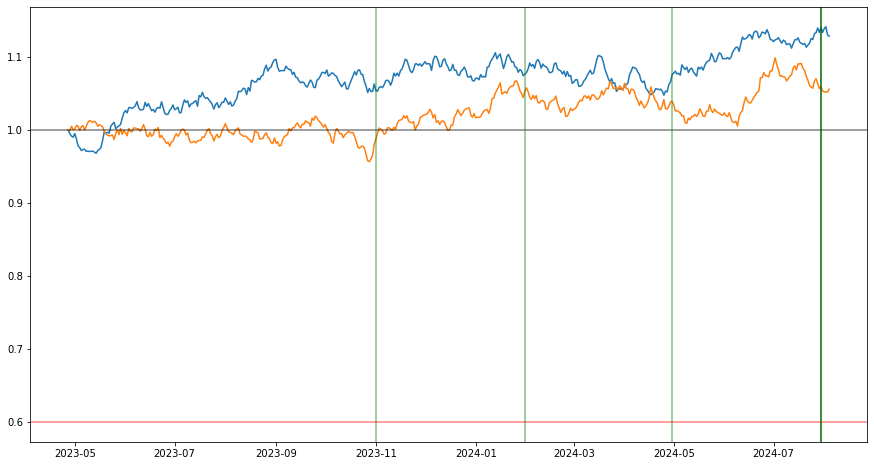

In [12]:
autocall_dates = [datetime.date.fromisoformat('2023-11-01'), datetime.date.fromisoformat('2024-01-31'), datetime.date.fromisoformat('2024-04-30')]
final_fixing_date = datetime.date.fromisoformat('2024-07-30')
plt.figure(figsize = (15, 8))
plt.plot(df_path1['date'], df_path1['price'])
plt.plot(df_path2['date'], df_path2['price'])
plt.axhline(y=1, c = "black", alpha = 0.5)
plt.axhline(y = 0.6, c = "red", alpha = 0.5)
plt.axvline(x = final_fixing_date, c = "darkgreen")
for date in autocall_dates:
    plt.axvline(x = date, c = "green", alpha = 0.5)

In [15]:

#return discounted payoff from df of payouts
#constant riskfree rate r, TODO varying r
def rnv(df_payouts, today, r):
    #ttp = time to payout
    df_payouts['ttp'] = (df_payouts['date'] - today).dt.days
    df_payouts['disc_price'] = df_payouts['payout'] * np.exp(-r * df_payouts['ttp'] / 365)
    return sum(df_payouts['disc_price'])


today = datetime.date.fromisoformat('2023-08-01')
print(df_payouts)
print(rnv(df_payouts, today, 0.02))

   payout        date  ttp  disc_price
0    20.0  2023-08-07    6   19.993426
0    20.0  2023-11-06   97   19.893981
0    20.0  2024-02-05  188   19.795030
0    20.0  2024-05-06  279   19.696572
0    20.0  2024-08-05  370   19.598603
0  1000.0  2024-08-05  370  979.930163
1078.9077741176375


In [9]:
N = 50
payoffs = []
today = datetime.date.fromisoformat('2023-08-01')
t_0 = datetime.date.fromisoformat('2023-04-27')
for i in range(N):
    df_path1 = genGBM(1, t_0, 0.08, 1, 1/365, 465)
    df_path2 = genGBM(1, t_0, 0.08, 1, 1/365, 465)
    df_payouts = payouts(df_path1, df_path2)
    payoffs.append(rnv(df_payouts, today, 0.02))
print(sum(payoffs) / N)

606.3736693189112
